In [1]:
# Script to evaluate citation delay
# Backward citation - citation made by a patent
# Forward citation - citation received by a patent

# Renato Kogeyama

# Jan 17 2020
# Join cit_delay with var_builder
# The only thing var_builder was doing was including kind and type 


# Jan 03 2020
# Miami
# I am using this script to calculate the average delay in citation - to follow Hall et al, 2001
# patent.csv has the following columns
# id 	type 	number 	country 	date 	abstract 	title 	kind 	num_claims 	filename
# interest on id, type, date, kind, num_claims

# I use two sources, uspatentcitation.tsv and patent.csv
# The first is a citation-level dataset with information about the citing patent
# The second is a patent-level dataset with information about the patent

# Cleaning
# I tested in other scripts the quality of the patent identifier
# It does not require cleaning - only 4 erros from 6 million patents
# The cleaning script is there anyway

# Merging
# I merge on the citation level (df)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
citation_df = '/home/rkogeyam/PATENT_CITATION/data/cleanuspatentcitation.csv'
# cit_tree = '/home/rkogeyam/PATENT_CITATION/data/cit_tree.csv'

patent= 'data/cleanpatent.csv'
dst='data/var_builder.csv'

# citation_df = r'/home/rkogeyam/PATENT_CITATION/data/uspatentcitation.tsv'
# dst = '/home/rkogeyam/PATENT_CITATION/data/back_cit_delay.csv'
# dst_forw = '/home/rkogeyam/PATENT_CITATION/data/forw_cit_delay.csv'

In [5]:
%%time
df = pd.read_csv(citation_df, usecols=['patent_id', 'citation_id', 'date'], dtype=object)

CPU times: user 2min 23s, sys: 9.65 s, total: 2min 33s
Wall time: 2min 33s


In [6]:
%%time
pt_df = pd.read_csv(patent, usecols=['id', 'date'],index_col=0, dtype=object)

In [7]:
# df=df.iloc[:,1:]

In [8]:
df.head()
# df.get_chunk().head()

,patent_id,citation_id,date
0,9009250,8127342,2012-02-01
1,9643605,5471515,1995-11-01
2,5354551,4875247,1989-10-01
3,D786922,D718330,2014-11-01
4,D490798,D190749,1961-06-01


In [9]:
pt_df.head()
# pt_df.get_chunk().head()

,date
id,
3930271,1976-01-06
3930272,1976-01-06
3930273,1976-01-06
3930274,1976-01-06
3930275,1976-01-06


In [10]:
%%time
df=df.rename(columns = {'date':'citation_date'})
df['citation_date']=pd.to_datetime(df['citation_date'], format="%Y-%m-%d", errors='coerce') 

In [11]:
%%time
# merge between patent data and citations on patent_id (citing)
# merging on the citation dataset drops patents without citing
# later i could standardize to make patent_id index and use join instead of merge

df=pd.merge(df, pt_df, how='inner', left_on='patent_id', right_index=True)

In [ ]:
df.info()

In [12]:
%%time
# date format to allow calculations
df=df.rename(columns = {'date':'patent_date'})
df['patent_date']=pd.to_datetime(df['patent_date'], format="%Y-%m-%d", errors='coerce') #conversao de string para data

In [13]:
# df.shape

In [14]:
# if I do not drop nans, the script raises an error later when converting day interval into years
# I could substitute with average instead of dropping, this way I do not lose the citation info
# however, not always it will be possible to average - cases where there is ony one citation, for example
# For this reason, at this point, I'll keep the NAN and circumvent the issues as they arise

# df=df.dropna()

In [15]:
# df.shape

In [16]:
# delay is the time interval between grant and citation
df['cit_delay']=df['patent_date'].sub(df['citation_date'], axis=0)

In [17]:
# convert to date format
df['cit_delay']=pd.to_timedelta(df['cit_delay'])

In [18]:
df.head()

,patent_id,citation_id,citation_date,patent_date,cit_delay
0,9009250,8127342,2012-02-01,2015-04-14,1168 days
537999,9009250,7593714,2009-09-01,2015-04-14,2051 days
736401,9009250,7177912,2007-02-01,2015-04-14,2994 days
836871,9009250,5819172,1998-10-01,2015-04-14,6039 days
1035358,9009250,6757696,2004-06-01,2015-04-14,3969 days


In [19]:
%%time
# convert to interval in years
# df['cit_delay']=df['cit_delay'].dt.days/360
df['cit_delay']=pd.to_timedelta(df['cit_delay']).dt.components.days/365 


In [20]:
df.describe()

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,cit_delay
count,8.904247e+07
mean,1.531295e+01
std,1.557046e+01
min,-2.904055e+02
25%,NaN
50%,NaN
75%,NaN
max,2.877836e+02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cf223e6a0>]], dtype=object)

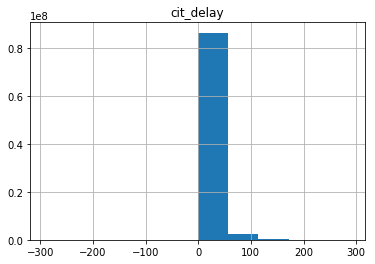

In [21]:
%%time
df.hist()

In [ ]:
#Check outliers
df[df["cit_delay"]>df["cit_delay"].quantile(0.01)]

In [ ]:
df[df["cit_delay"]<df["cit_delay"].quantile(0.99)]

In [22]:
df.to_csv(dst)